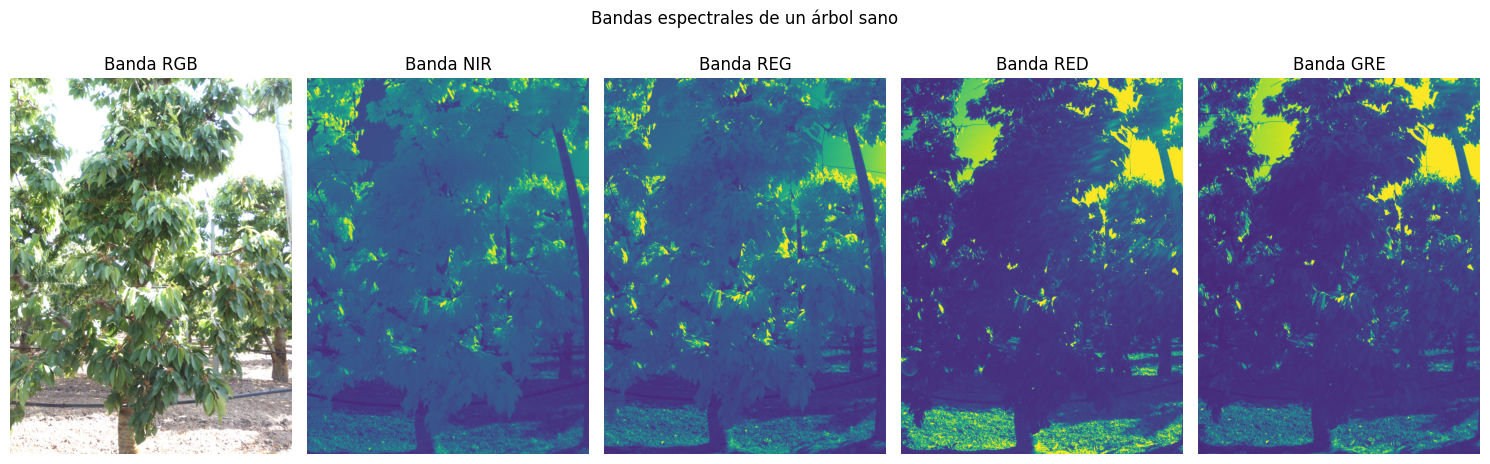

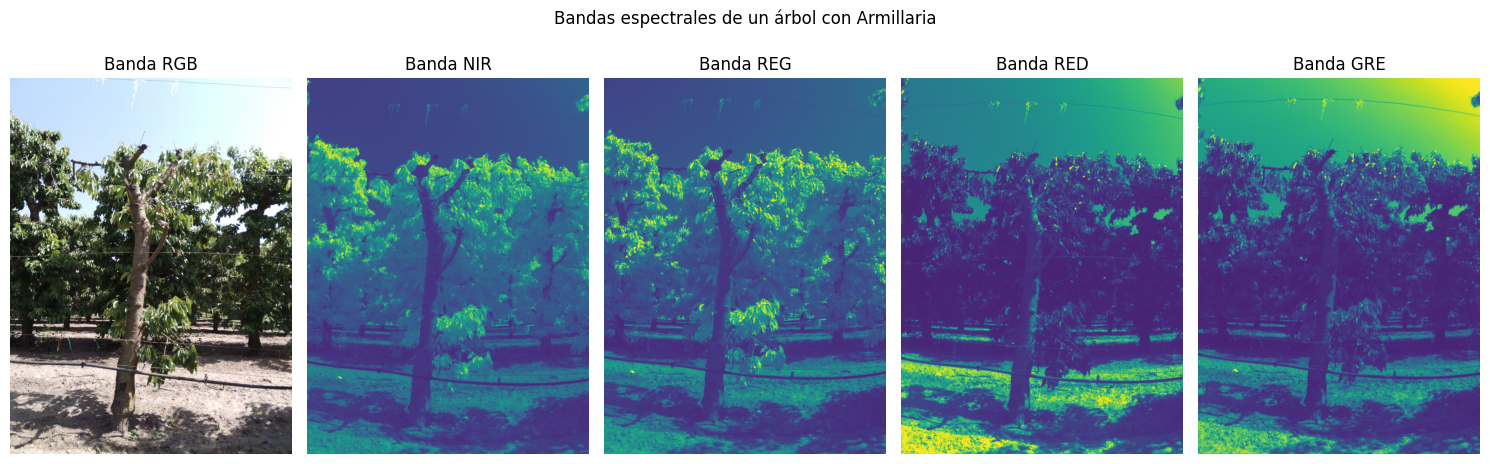

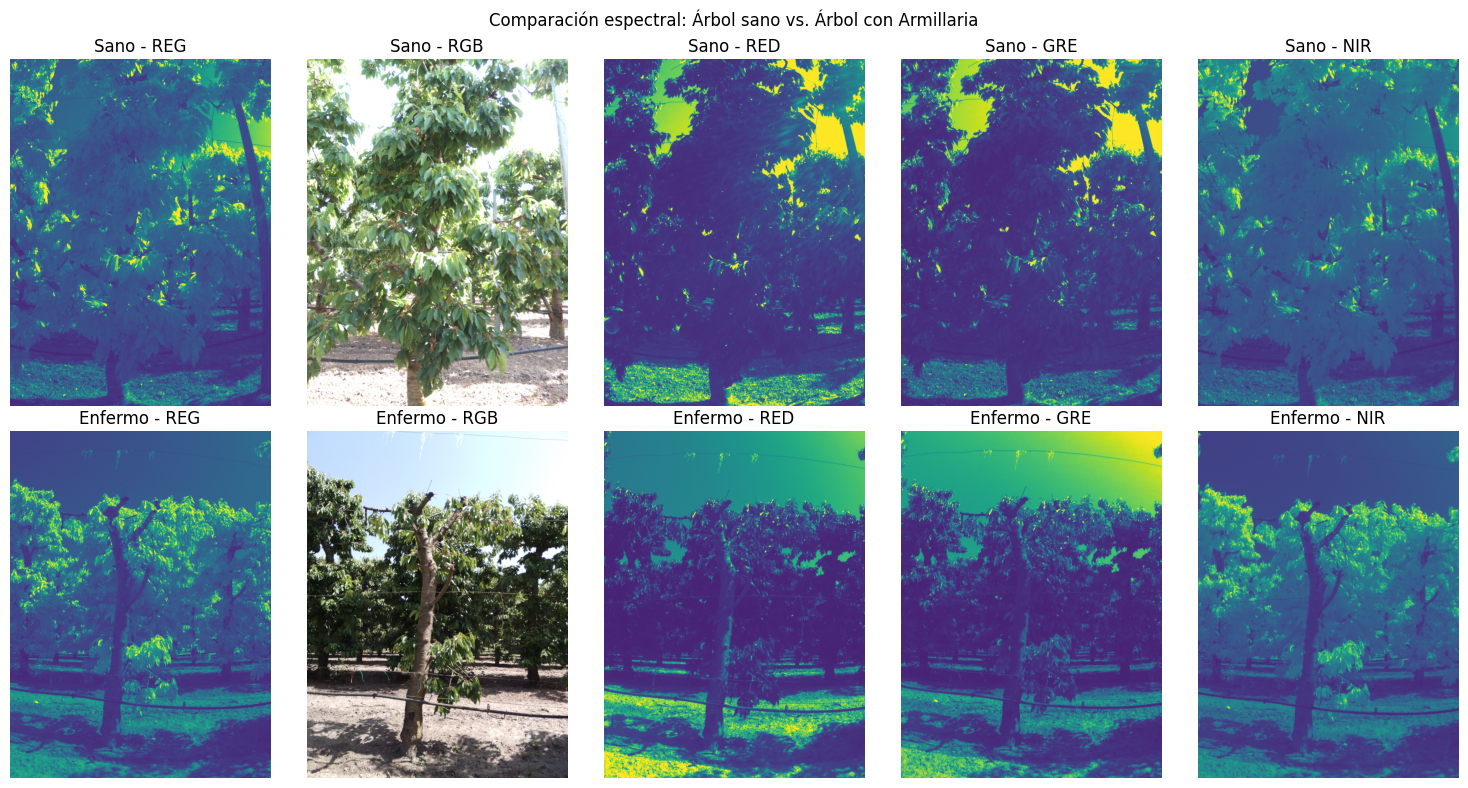

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
from funciones_auxiliares import crop_central_region


# Función para cargar y preprocesar imágenes multiespectrales
def load_multispectral_image(base_path, image_prefix):
    images = {}
    
    # Cargar imagen RGB (JPG)
    rgb_path = os.path.join(base_path, f"{image_prefix}_RGB.JPG")
    if os.path.exists(rgb_path):
        rgb_img = cv2.imread(rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB
        images['RGB'] = rgb_img
    
    # Cargar bandas multiespectrales (TIFF)
    for band in ['NIR', 'REG', 'RED', 'GRE']:
        band_path = os.path.join(base_path, f"{image_prefix}_{band}.TIF")
        if os.path.exists(band_path):
            # Las imágenes TIFF son de 16 bits, hay que normalizarlas a 8 bits para visualización
            img = cv2.imread(band_path, cv2.IMREAD_UNCHANGED)
            
            # Normalizar a rango 0-255
            if img.dtype == np.uint16:
                img = (img / 65535 * 255).astype(np.uint8)
            
            # Aplicar un mapa de color para visualización (por ejemplo, 'jet')
            # Esto es opcional, pero facilita la visualización de bandas monocromáticas
            img_colored = cv2.applyColorMap(img, cv2.COLORMAP_VIRIDIS)
            img_colored = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)
            images[band] = img_colored
    
    return images

# Función para visualizar todas las bandas
def visualize_spectral_bands(images, title="Bandas espectrales de un árbol de cerezo"):
    n_bands = len(images)
    fig, axes = plt.subplots(1, n_bands, figsize=(15, 5))
    
    # Si solo hay una banda, axes no será una matriz
    if n_bands == 1:
        axes = [axes]
    
    for i, (band_name, img) in enumerate(images.items()):
        axes[i].imshow(img)
        axes[i].set_title(f"Banda {band_name}")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Función para comparar árboles sanos vs enfermos
def compare_healthy_vs_diseased(healthy_path, diseased_path, healthy_prefix, diseased_prefix):
    # Cargar imágenes
    healthy_images = load_multispectral_image(healthy_path, healthy_prefix)
    diseased_images = load_multispectral_image(diseased_path, diseased_prefix)
    
    # Obtener bandas comunes
    bands = list(set(healthy_images.keys()) & set(diseased_images.keys()))
    
    # Crear figura
    fig, axes = plt.subplots(2, len(bands), figsize=(15, 8))
    
    # Mostrar imágenes
    for i, band in enumerate(bands):
        axes[0, i].imshow(healthy_images[band])
        axes[0, i].set_title(f"Sano - {band}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(diseased_images[band])
        axes[1, i].set_title(f"Enfermo - {band}")
        axes[1, i].axis('off')
    
    plt.suptitle("Comparación espectral: Árbol sano vs. Árbol con Armillaria")
    plt.tight_layout()
    return fig

# Ejemplo de uso (ajusta las rutas según tu estructura de directorios)
base_path = "/mnt/d/M/TFMAgricultura/7144071"
healthy_path = os.path.join(base_path, "26_05_2022/Ground_Multispectral_Photos/Healthy/2-6")
diseased_path = os.path.join(base_path, "26_05_2022/Ground_Multispectral_Photos/Armillaria_Stage_2/7-58")

# Prefijos de imagen específicos (ajusta según tus datos)
healthy_prefix = "IMG_700101_001259_0000"
diseased_prefix = "IMG_700101_000426_0000"

# Visualización de un árbol sano en todas sus bandas
healthy_images = load_multispectral_image(healthy_path, healthy_prefix)
fig1 = visualize_spectral_bands(healthy_images, "Bandas espectrales de un árbol sano")
fig1.savefig("espectros_arbol_sano.png", dpi=300, bbox_inches='tight')

# Visualización de un árbol enfermo en todas sus bandas
diseased_images = load_multispectral_image(diseased_path, diseased_prefix)
fig2 = visualize_spectral_bands(diseased_images, "Bandas espectrales de un árbol con Armillaria")
fig2.savefig("espectros_arbol_enfermo.png", dpi=300, bbox_inches='tight')

# Comparación entre árbol sano y enfermo
fig3 = compare_healthy_vs_diseased(healthy_path, diseased_path, healthy_prefix, diseased_prefix)
fig3.savefig("comparacion_espectral_sano_vs_enfermo.png", dpi=300, bbox_inches='tight')

plt.show()

In [4]:
from auxii import plot_spectra, analyze_image, analyze_tiff_metadata

image_path3 = "/mnt/d/Maestria/tfm/7144071/16_09_2021/Ground_RGB_Photos/Armillaria_Stage_2/6-66.jpg"  
image_path = "/mnt/d/Maestria/tfm/7144071/16_09_2021/Ground_Multispectral_Photos/Armillaria_Stage_2/6-60/IMG_160101_000628_0000_RED.TIF"
analyze_tiff_metadata(image_path)
analyze_image(image_path)

ModuleNotFoundError: No module named 'auxii'

In [5]:
def plot_intensity_histograms(healthy_image, diseased_image, band):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Convertir a escala de grises si es RGB
    if len(healthy_image.shape) == 3 and healthy_image.shape[2] == 3:
        healthy_gray = cv2.cvtColor(healthy_image, cv2.COLOR_RGB2GRAY)
        diseased_gray = cv2.cvtColor(diseased_image, cv2.COLOR_RGB2GRAY)
    else:
        healthy_gray = healthy_image
        diseased_gray = diseased_image
    
    # Calcular histogramas
    ax[0].hist(healthy_gray.flatten(), bins=50, alpha=0.7, color='green', label='Sano')
    ax[0].hist(diseased_gray.flatten(), bins=50, alpha=0.7, color='red', label='Enfermo')
    ax[0].set_title(f'Histograma banda {band}')
    ax[0].set_xlabel('Intensidad de píxel')
    ax[0].set_ylabel('Frecuencia')
    ax[0].legend()
    
    # Gráfico de densidad acumulativa
    ax[1].hist(healthy_gray.flatten(), bins=50, alpha=0.7, color='green', 
               cumulative=True, density=True, label='Sano')
    ax[1].hist(diseased_gray.flatten(), bins=50, alpha=0.7, color='red', 
               cumulative=True, density=True, label='Enfermo')
    ax[1].set_title(f'Distribución acumulativa - {band}')
    ax[1].set_xlabel('Intensidad de píxel')
    ax[1].set_ylabel('Frecuencia acumulada')
    ax[1].legend()
    
    plt.tight_layout()
    return fig

def generate_all_histograms(healthy_images, diseased_images):
    """Genera histogramas para todas las bandas espectrales comunes"""
    
    # Obtener bandas comunes en ambas imágenes
    common_bands = set(healthy_images.keys()) & set(diseased_images.keys())
    
    histograms = {}
    for band in common_bands:
        # Obtener las imágenes de esta banda
        healthy_band = healthy_images[band]
        diseased_band = diseased_images[band]
        
        # Generar el histograma
        fig = plot_intensity_histograms(healthy_band, diseased_band, band)
        
        # Guardar el histograma
        output_filename = f"histograma_{band}.png"
        fig.savefig(output_filename, dpi=300, bbox_inches='tight')
        
        histograms[band] = output_filename
        plt.close(fig)  # Cerrar la figura para liberar memoria
    
    return histograms

healthy_images = load_multispectral_image(healthy_path, healthy_prefix)
diseased_images = load_multispectral_image(diseased_path, diseased_prefix)

# Generar histogramas para todas las bandas
histogram_files = generate_all_histograms(healthy_images, diseased_images)

print("Histogramas generados:")
for band, filename in histogram_files.items():
    print(f"- Banda {band}: {filename}")

Histogramas generados:
- Banda REG: histograma_REG.png
- Banda RGB: histograma_RGB.png
- Banda RED: histograma_RED.png
- Banda GRE: histograma_GRE.png
- Banda NIR: histograma_NIR.png


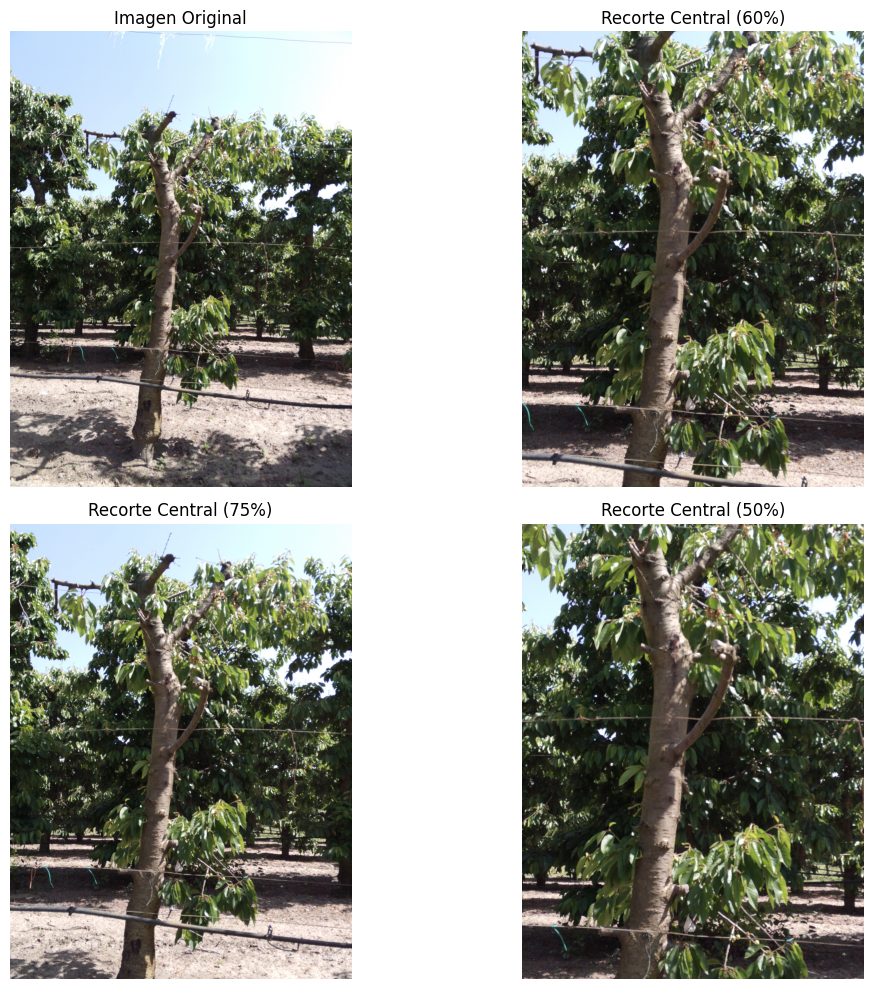

<Figure size 640x480 with 0 Axes>

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Ruta a tu imagen (reemplaza con la ruta real)
image_path = "/mnt/d/M/TFMAgricultura/7144071/26_05_2022/Ground_Multispectral_Photos/Armillaria_Stage_2/7-58/IMG_700101_000426_0000_RGB.JPG"  # Reemplaza con la ruta a tu imagen

# Cargar la imagen
image = cv2.imread(image_path)
if image is None:
    print(f"Error: No se pudo cargar la imagen en {image_path}")
else:
    # Convertir de BGR a RGB (cv2 carga en BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Aplicar recorte central con diferentes ratios
    cropped_60 = crop_central_region(image, center_ratio=0.6)
    cropped_75 = crop_central_region(image, center_ratio=0.75)
    cropped_50 = crop_central_region(image, center_ratio=0.5)
    
    # Visualizar resultados
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Imagen Original")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cropped_60)
    axes[0, 1].set_title("Recorte Central (60%)")
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(cropped_75)
    axes[1, 0].set_title("Recorte Central (75%)")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(cropped_50)
    axes[1, 1].set_title("Recorte Central (50%)")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Opcionalmente, guardar la comparación
    plt.savefig("comparacion_recortes_centrales.png", dpi=300, bbox_inches='tight')